In [1]:
from torch.utils.data import DataLoader, Dataset

import zarr

import gunpowder as gp

In [2]:
train_data = zarr.open('./dataset/BBBC039.zarr/train_data/', 'r')

In [3]:
len(train_data)

100

In [4]:

raw = gp.ArrayKey('RAW')
source = gp.ZarrSource(
    './dataset/BBBC039.zarr/train_data/',
    {raw: '{}/0'.format(0)},
    {raw: gp.ArraySpec(interpolatable=True, voxel_size=(1, 1))}
)

    
pipeline = source + gp.RandomLocation()

In [5]:
request = gp.BatchRequest()

In [6]:
request[raw] = gp.Roi((0,0), (64, 64))

In [7]:
with gp.build(pipeline):
    batch = pipeline.request_batch(request)

In [8]:
raw

RAW

In [9]:
from matplotlib import pyplot as plt

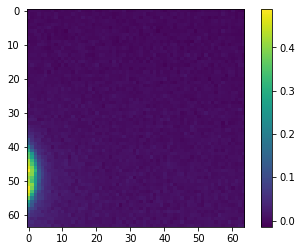

In [10]:
plt.imshow(batch[raw].data[0])
plt.colorbar()

In [11]:
batch


	RAW: ROI: [0:64, 0:64] (64, 64), voxel size: (1, 1), interpolatable: True, non-spatial: False, dtype: float32, placeholder: False

In [12]:
train_data = zarr.open('./dataset/BBBC039.zarr', 'r')['train_data']

In [13]:
len(train_data)

100

In [14]:
train_data.get(0).attrs['dataspecs']

{'axes': ['c', 'y', 'x'],
 'data_spacing': [1.0, 1.0, 1.0],
 'shape': [1, 520, 696],
 'source_file': '/home/tibuch/Data/broad/nuclei_U2OS/images/IXMtest_A06_s6_w1B9577918-4973-4A87-BA73-A168AA755527.tif'}

In [15]:
item = train_data.get(0)

In [16]:
item[0]

<zarr.core.Array '/train_data/0/0' (1, 520, 696) float32 read-only>

In [49]:
class ZarrDataset(Dataset):
    def __init__(self, path, target_name='nuclei', shape=(64, 64), transform=(gp.RandomLocation() + gp.SimpleAugment())):
        self.path = path
        self.raw = gp.ArrayKey('RAW')
        self.gt = gp.ArrayKey('GT')
        self.request = gp.BatchRequest()
        self.request[self.raw] = gp.Roi((0,) * len(shape), shape)
        self.request[self.gt] = gp.Roi((0,) * len(shape), shape)
        self.pipelines = []
        for i in range(len(zarr.open(path))):            
            source = gp.ZarrSource(
                    path,
                    {self.raw: '{}/0'.format(i)},
                    {self.raw: gp.ArraySpec(interpolatable=True, voxel_size=(1,) * len(shape))}
                )
            
            target = gp.ZarrSource(
                path,
                {self.gt: '{}/labels/{}/0'.format(i, target_name)},
                {self.gt: gp.ArraySpec(interpolatable=False, voxel_size=(1,) * len(shape))}
            )
            
            combined = (source, target) + gp.MergeProvider()
            self.pipelines.append((combined,) + transform)
            
        
    def __len__(self):
        return len(self.pipelines)
    
    def __getitem__(self, idx):
        pipeline = self.pipelines[idx]
        with gp.build(pipeline):
            batch = pipeline.request_batch(self.request)
        return np.moveaxis(batch[self.raw].data, 0, -1).copy(), np.moveaxis(batch[self.gt].data, 0, -1).copy()
        

In [50]:
ds = ZarrDataset('./dataset/BBBC039.zarr/train_data/')

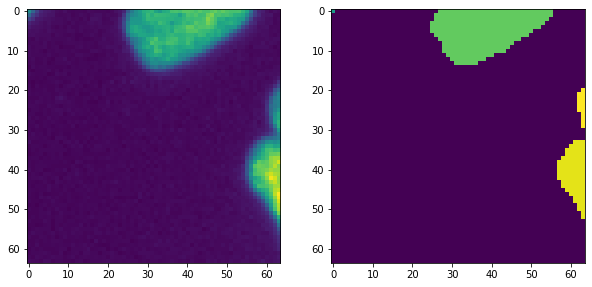

In [51]:
raw, gt = ds.__getitem__(10)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(raw[...,0])
plt.subplot(1,2,2)
plt.imshow(gt[...,0])

In [52]:
from torch.utils.data import DataLoader

In [53]:
dl = DataLoader(ds, batch_size=5)

In [57]:
len(dl)

20

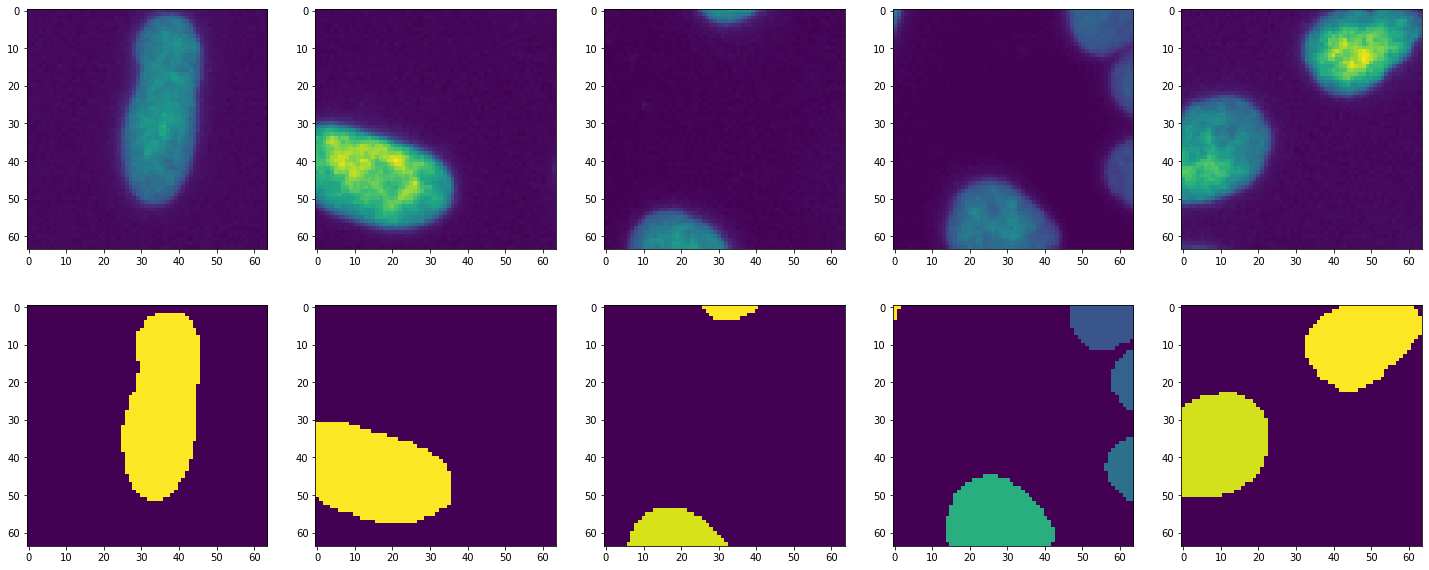

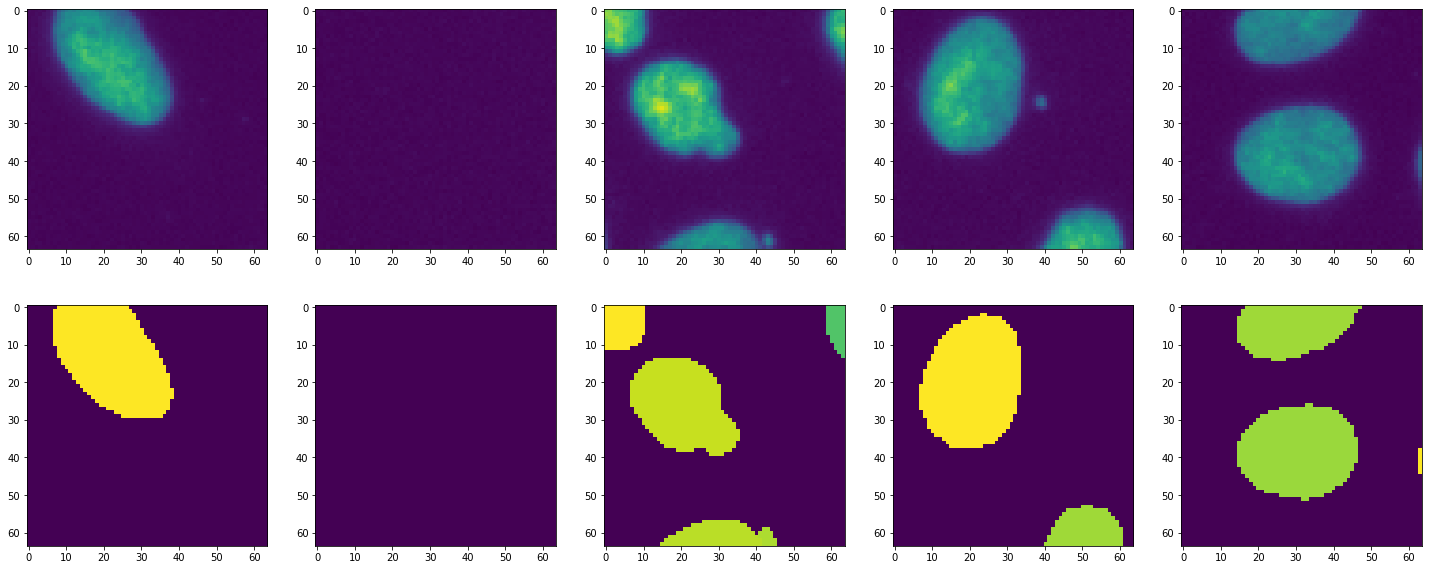

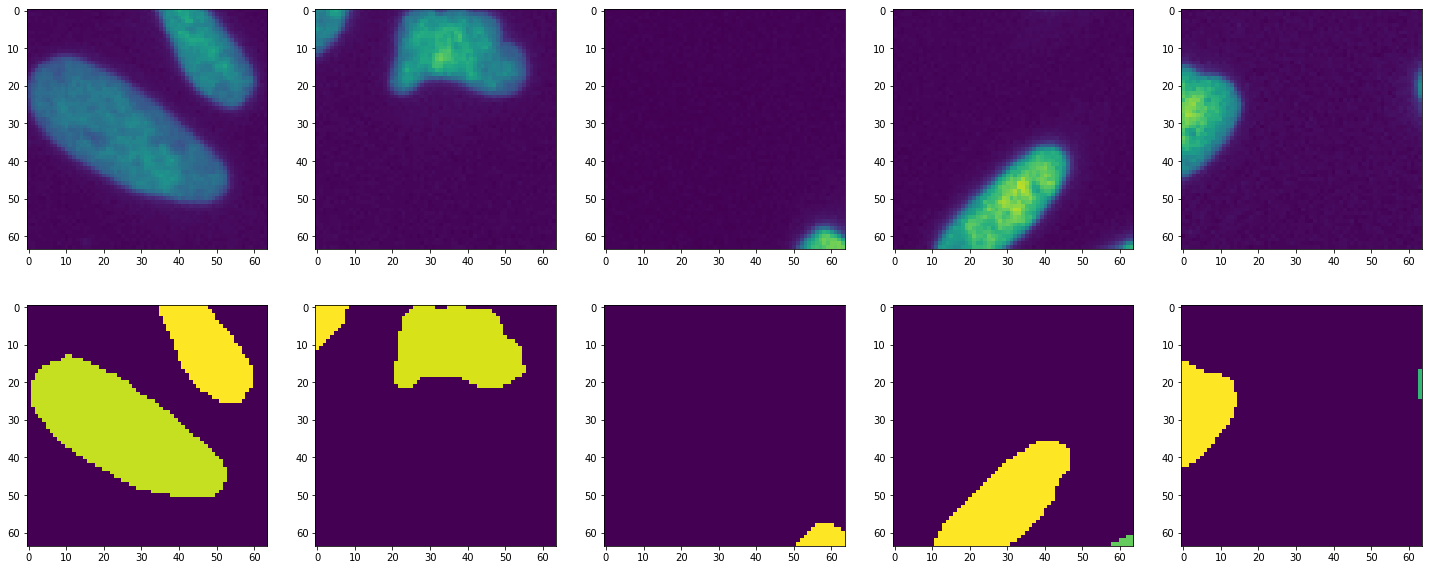

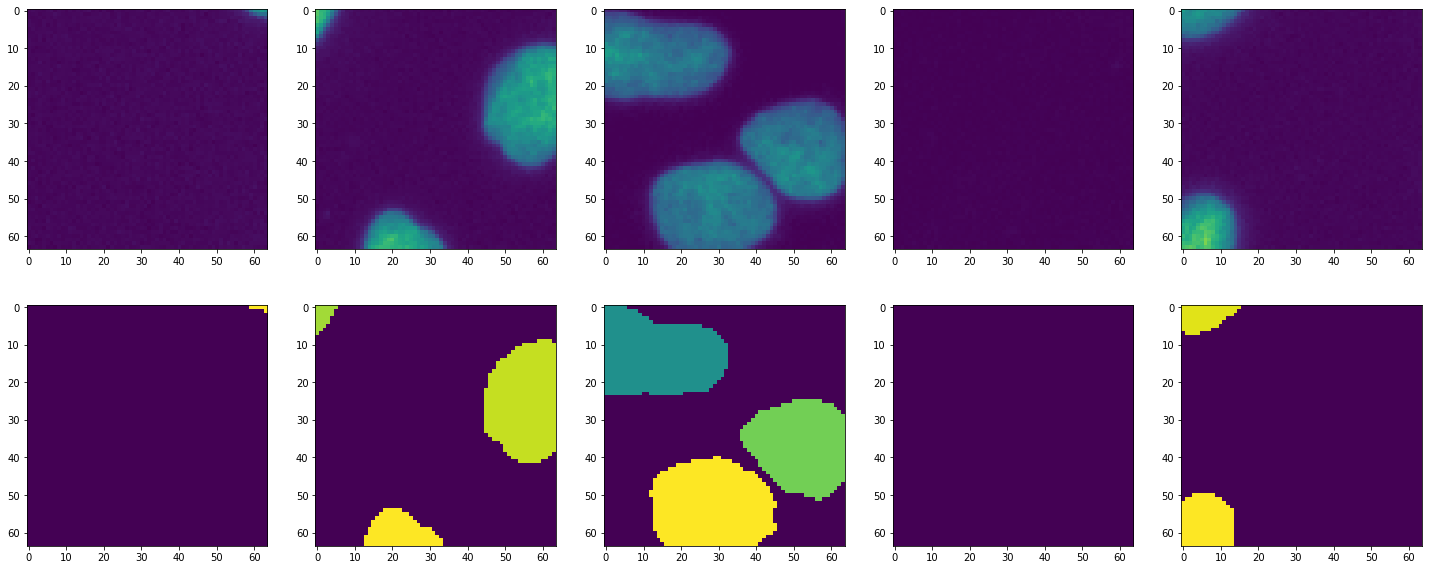

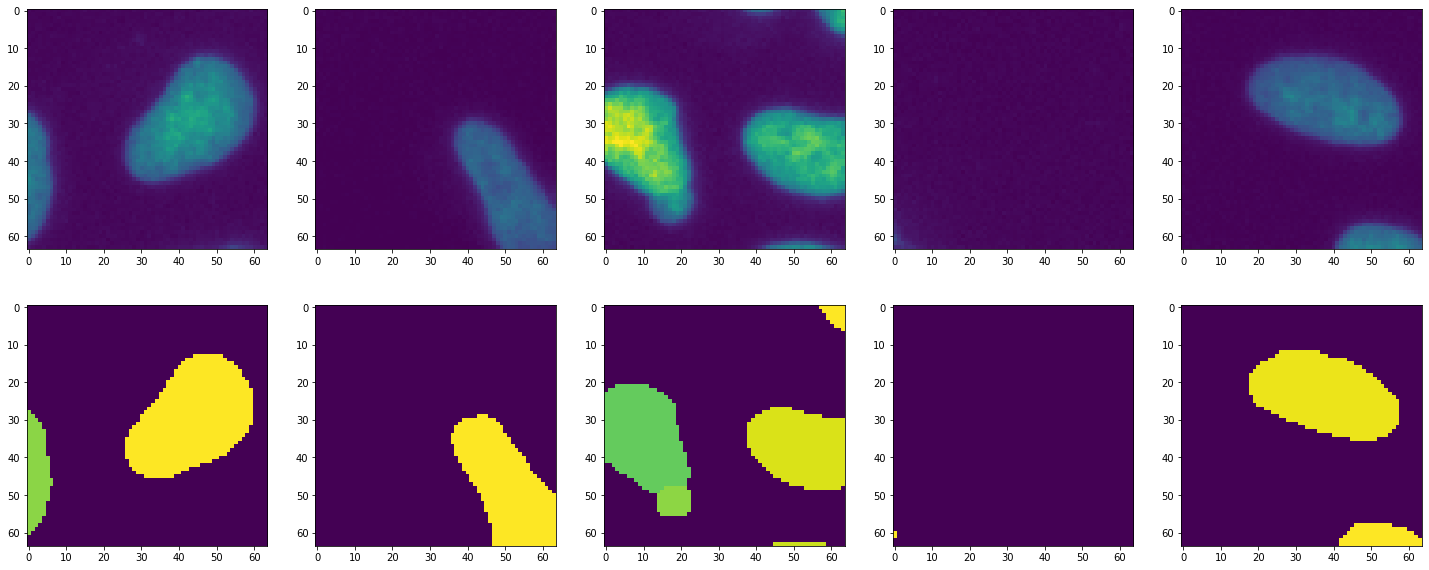

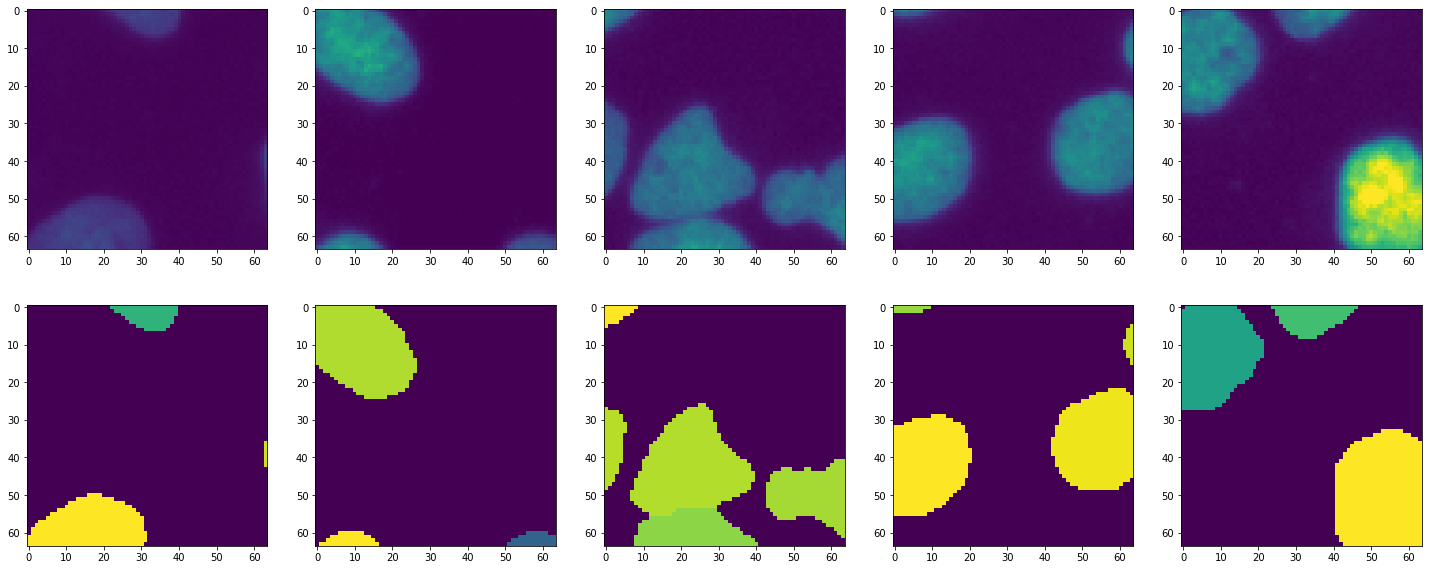

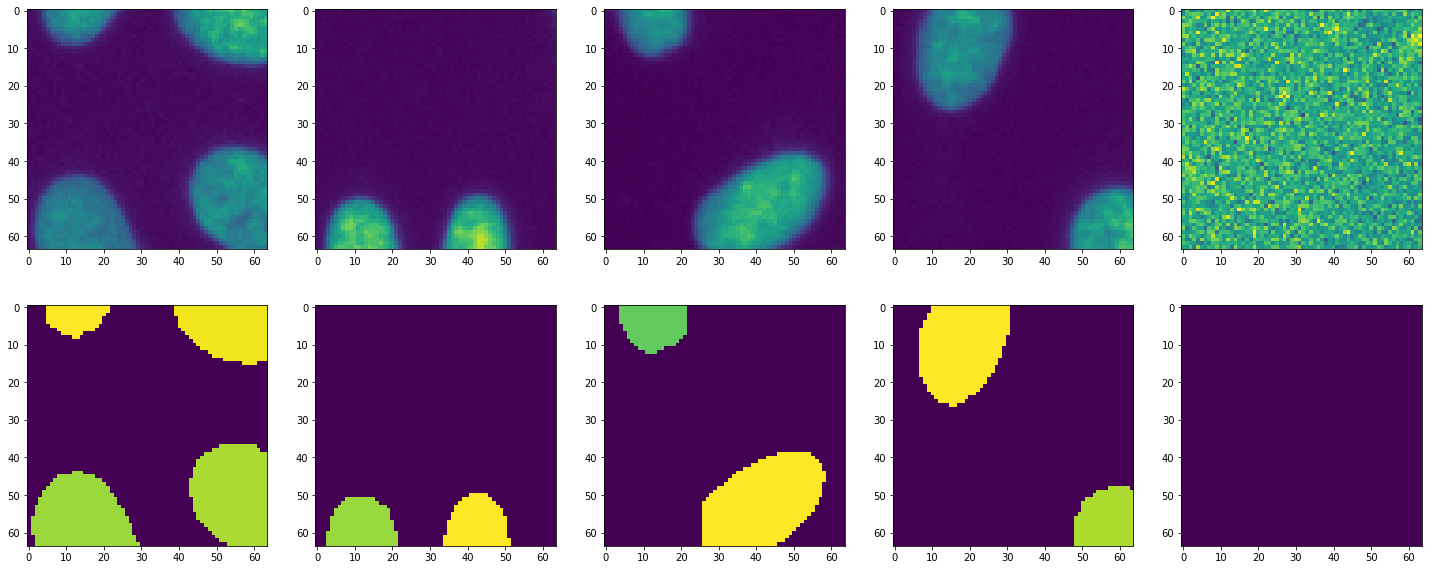

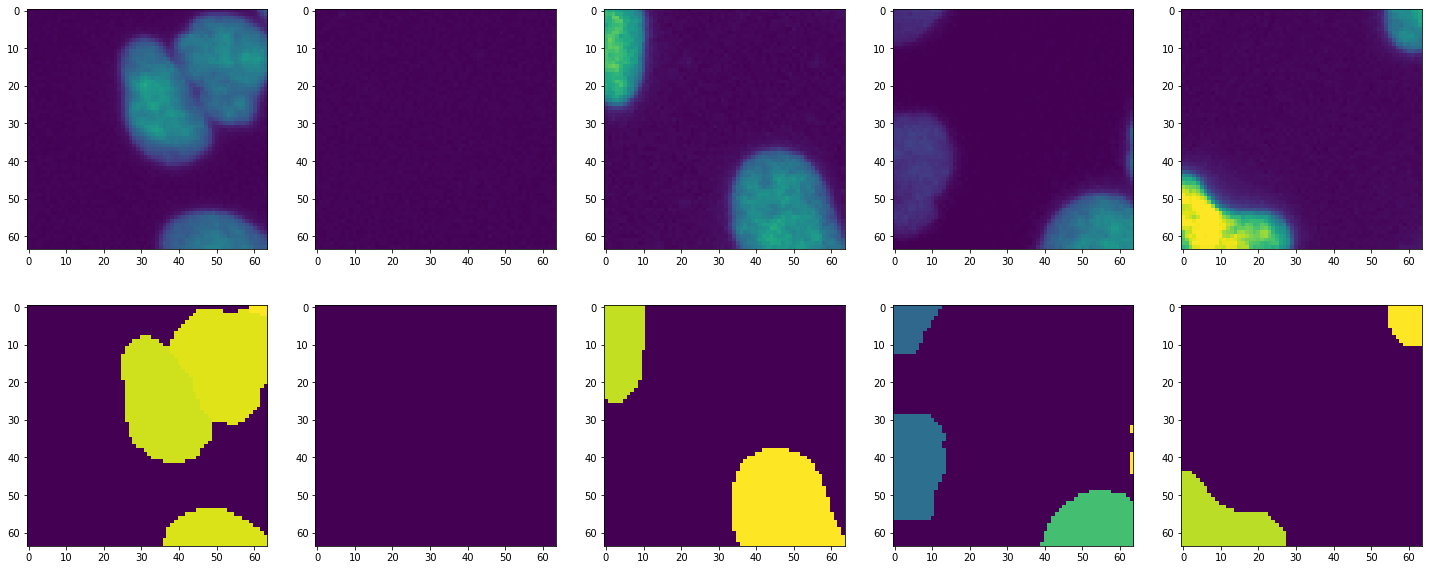

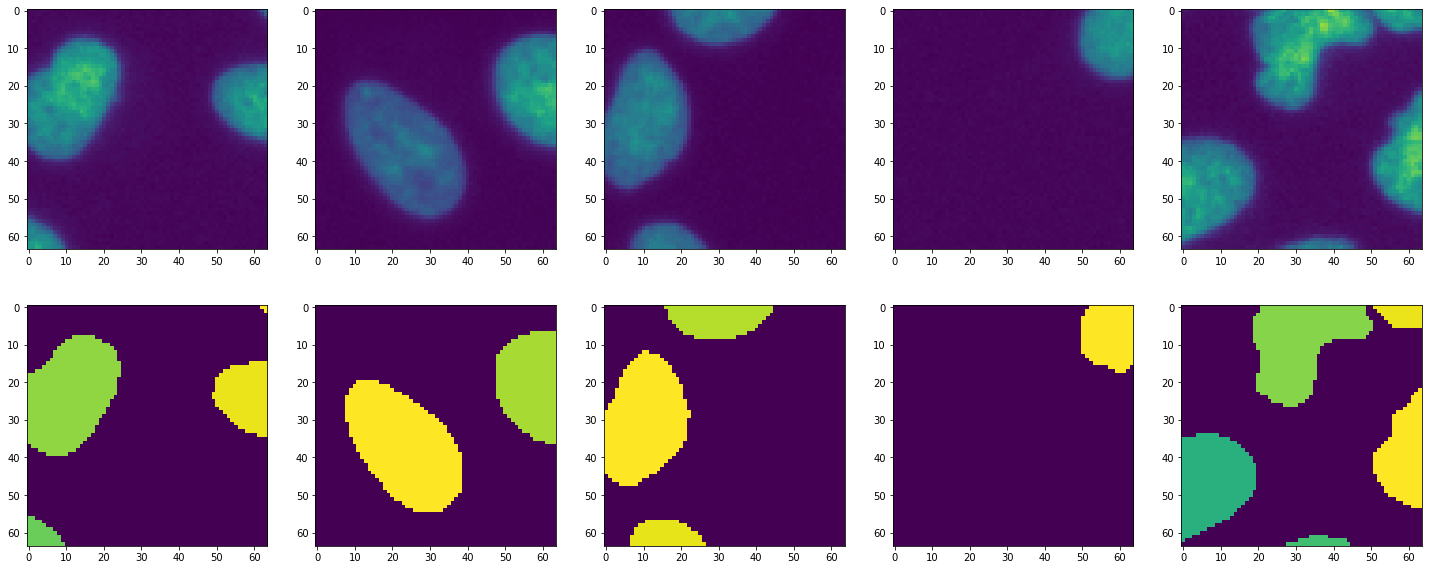

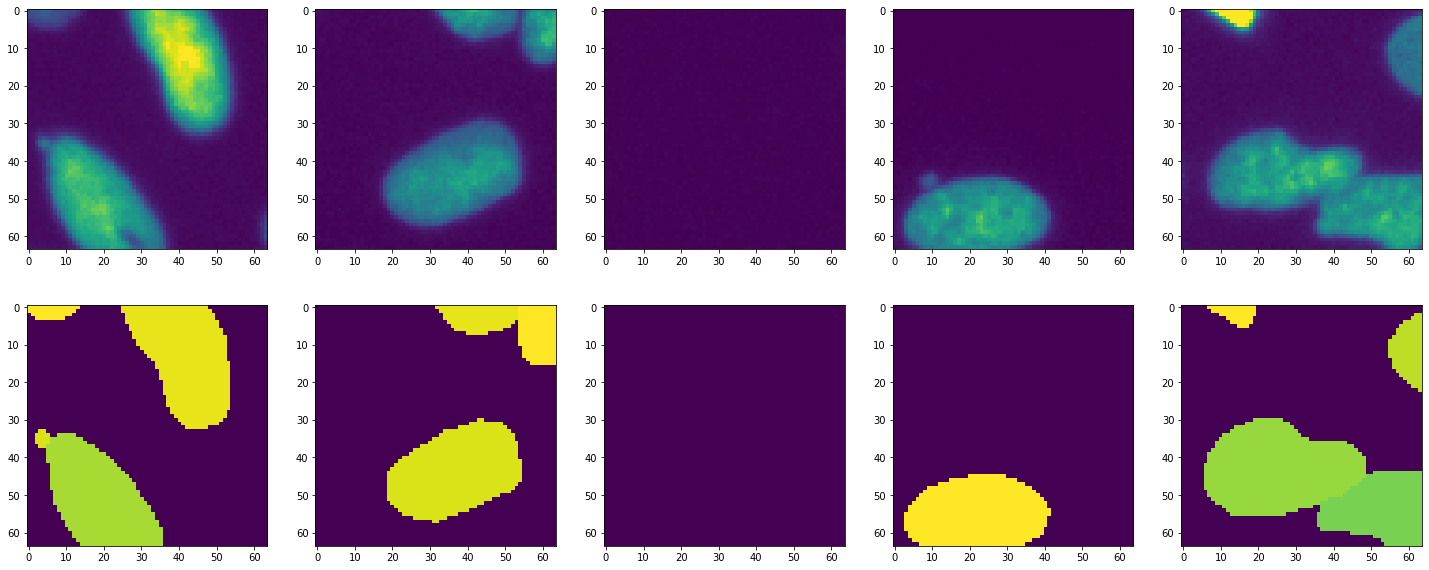

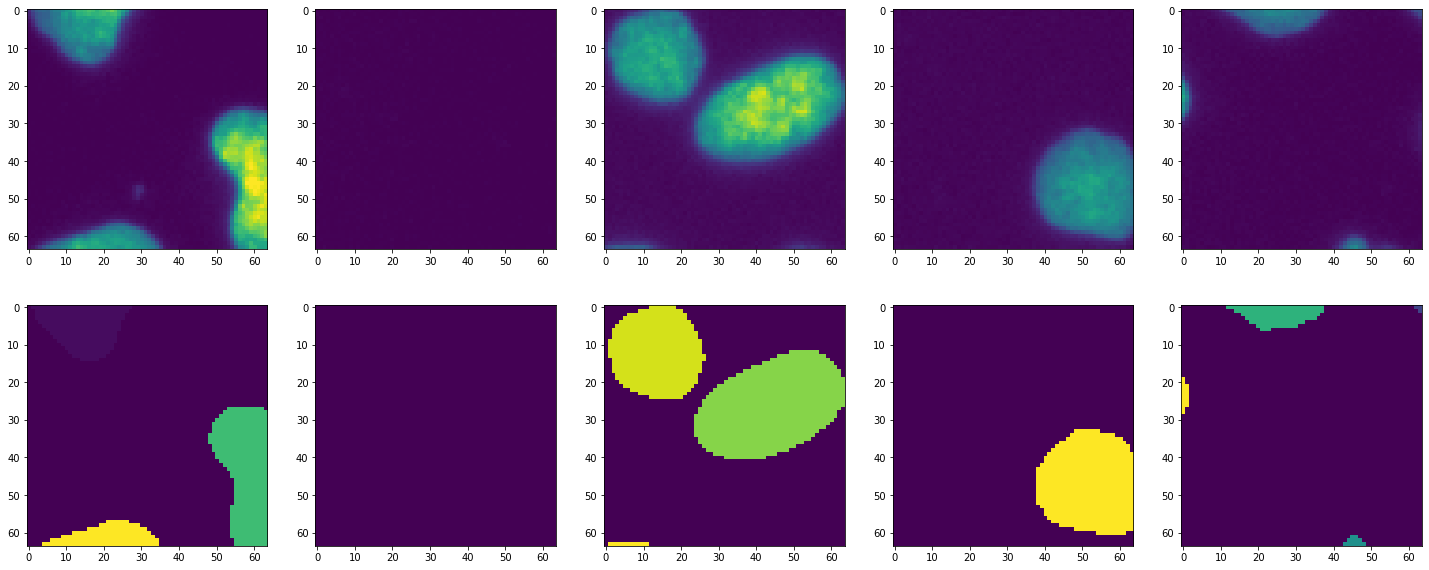

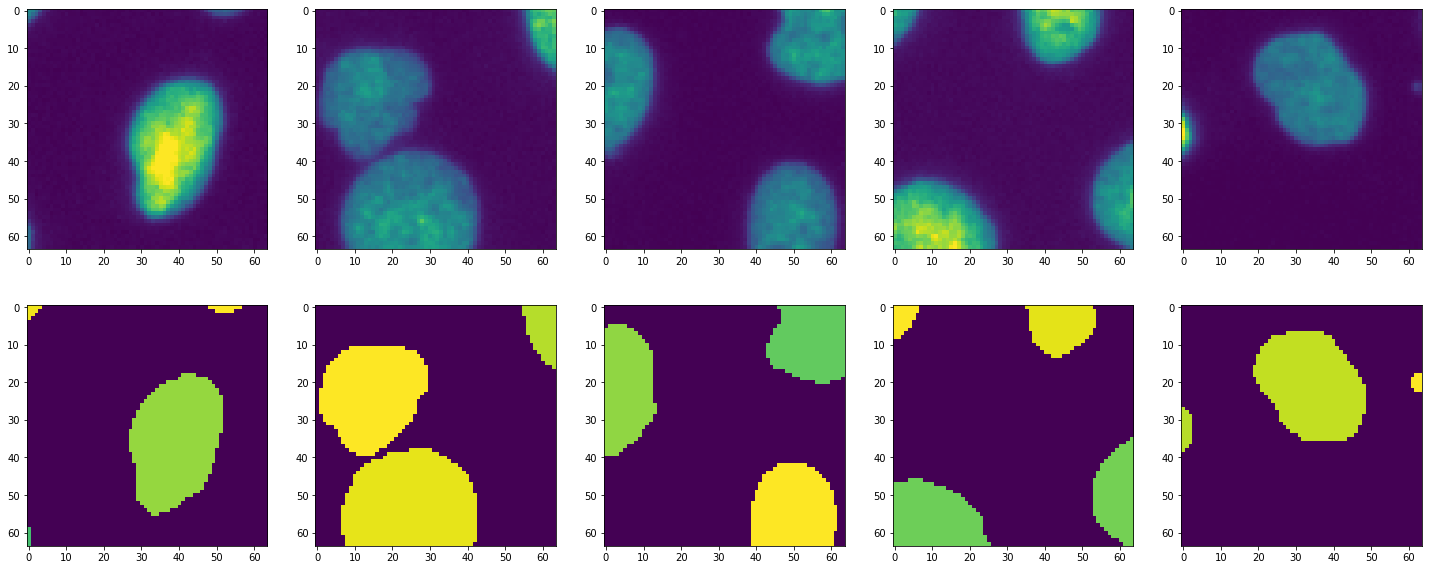

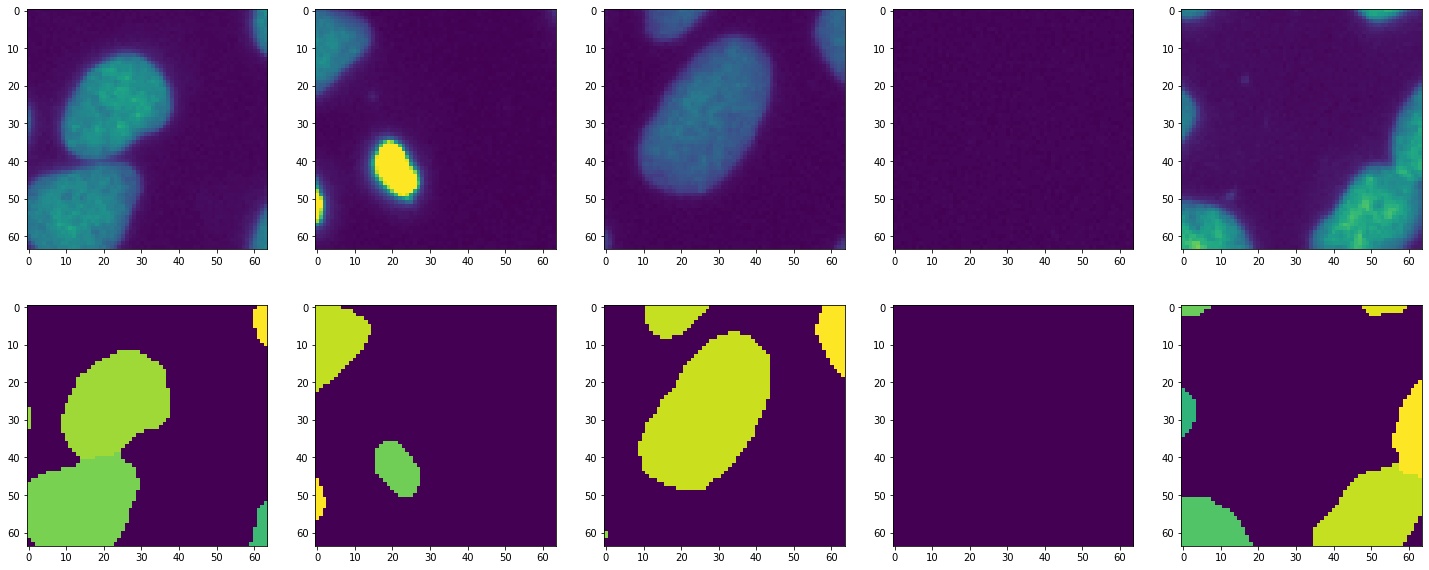

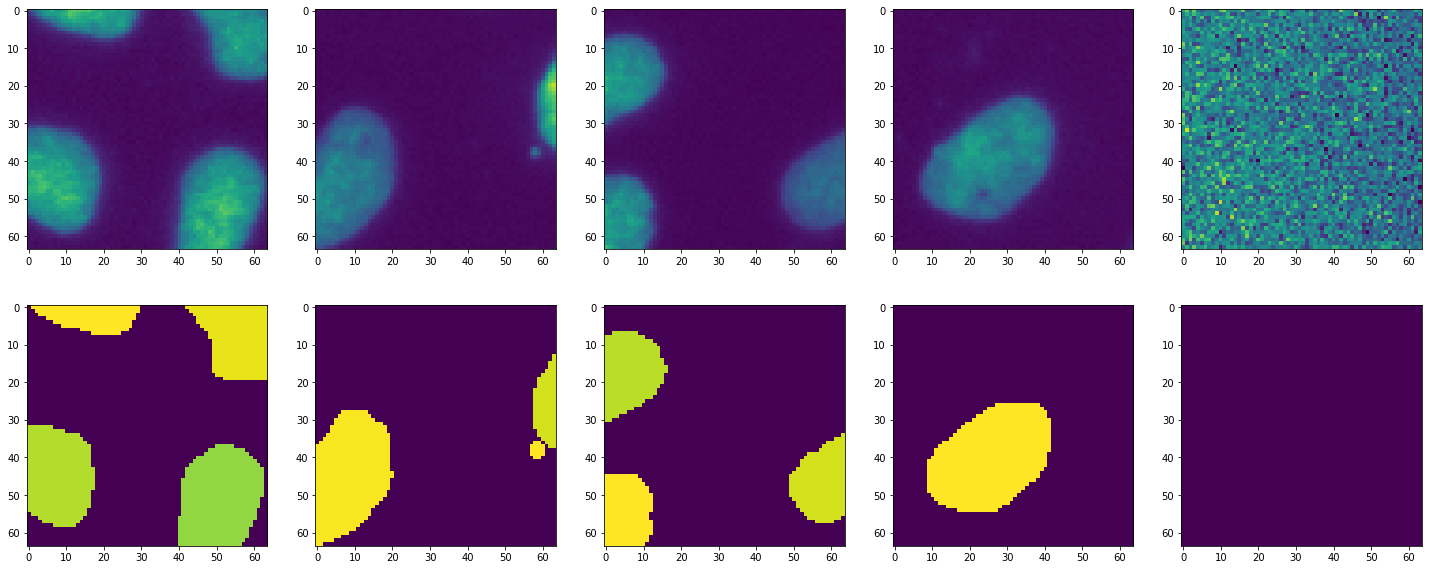

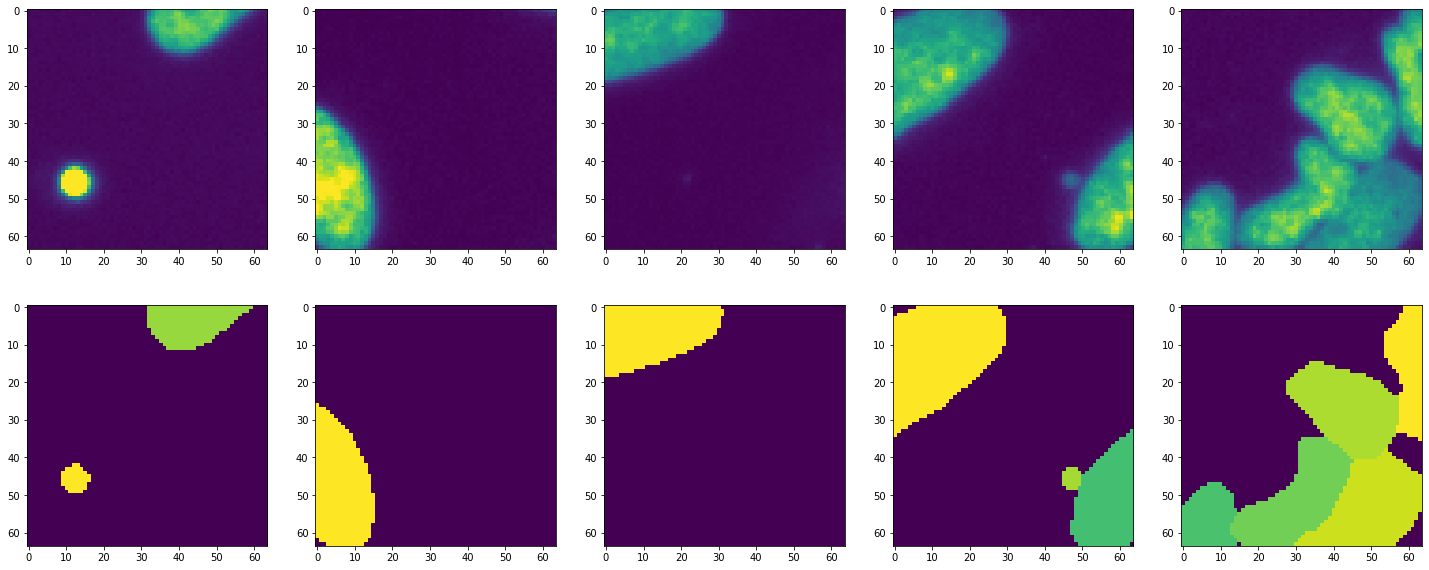

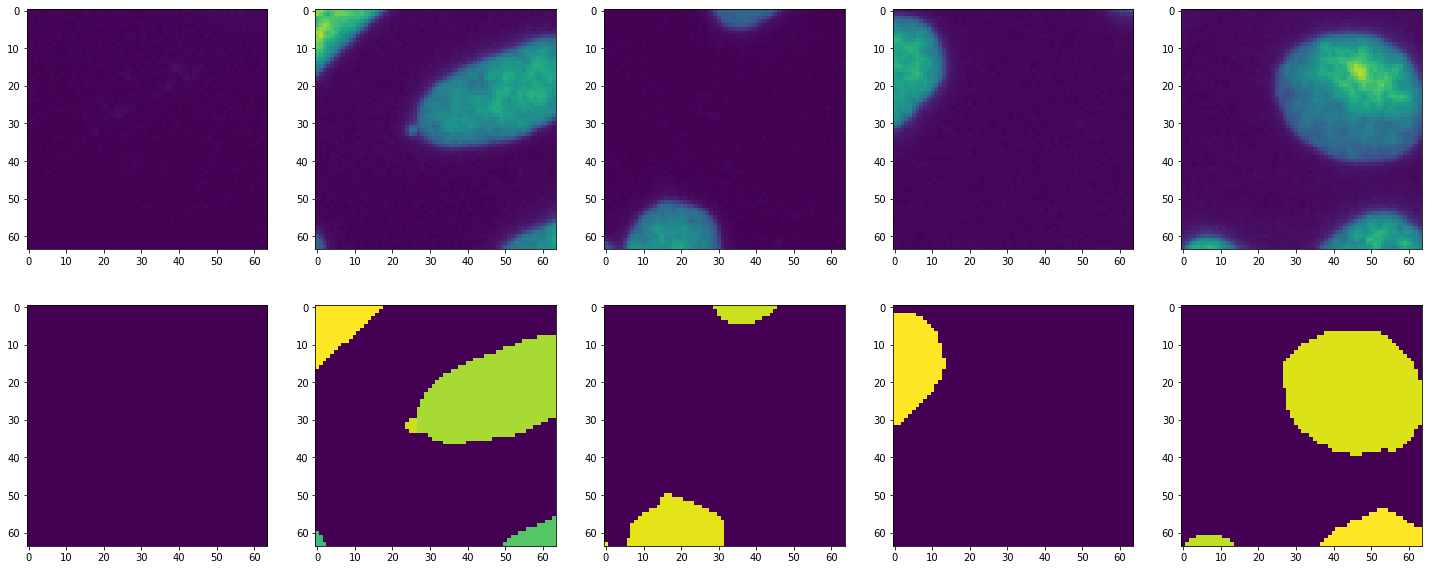

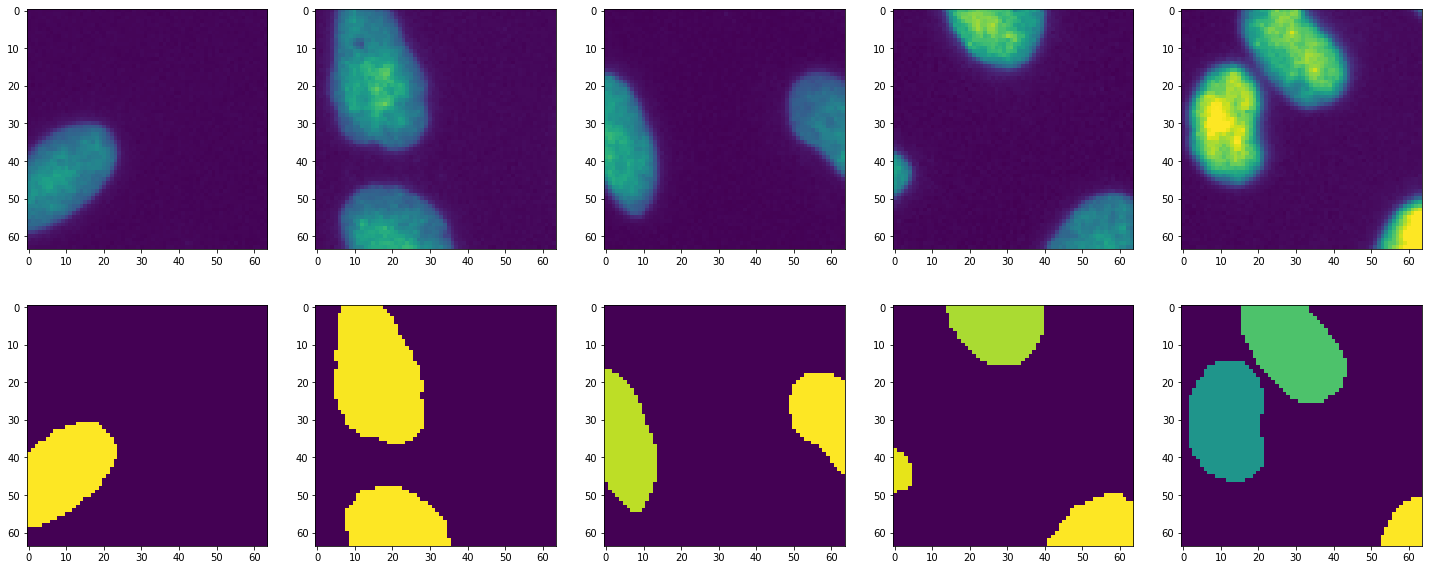

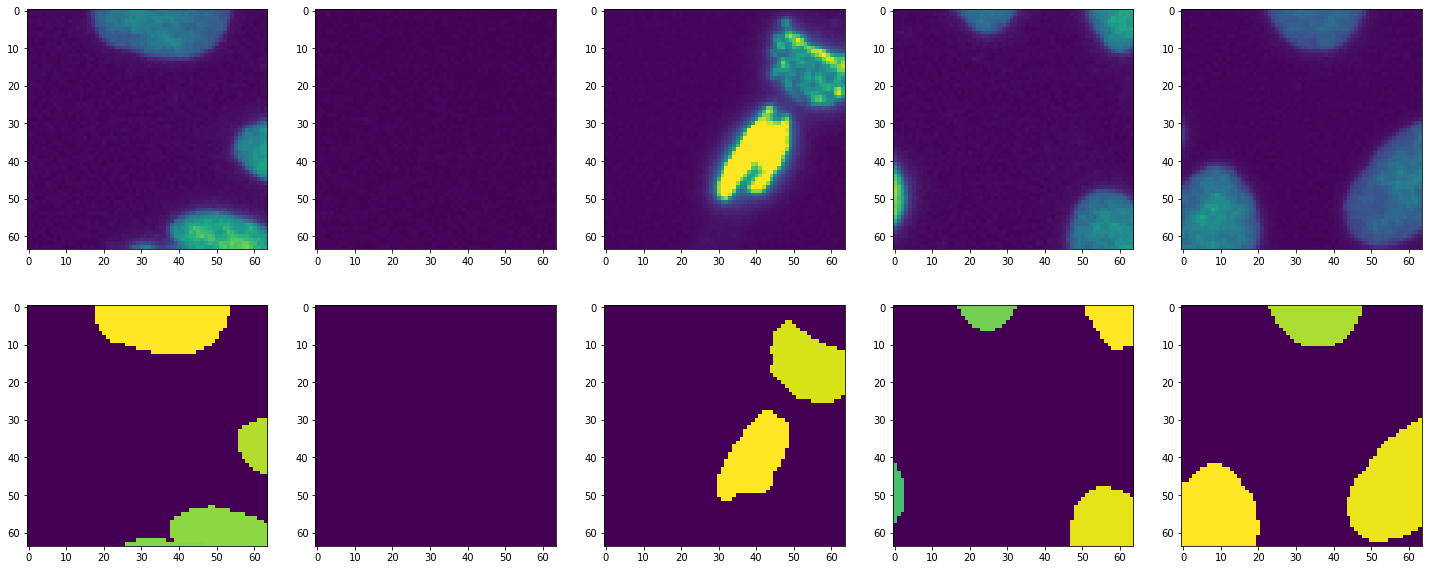

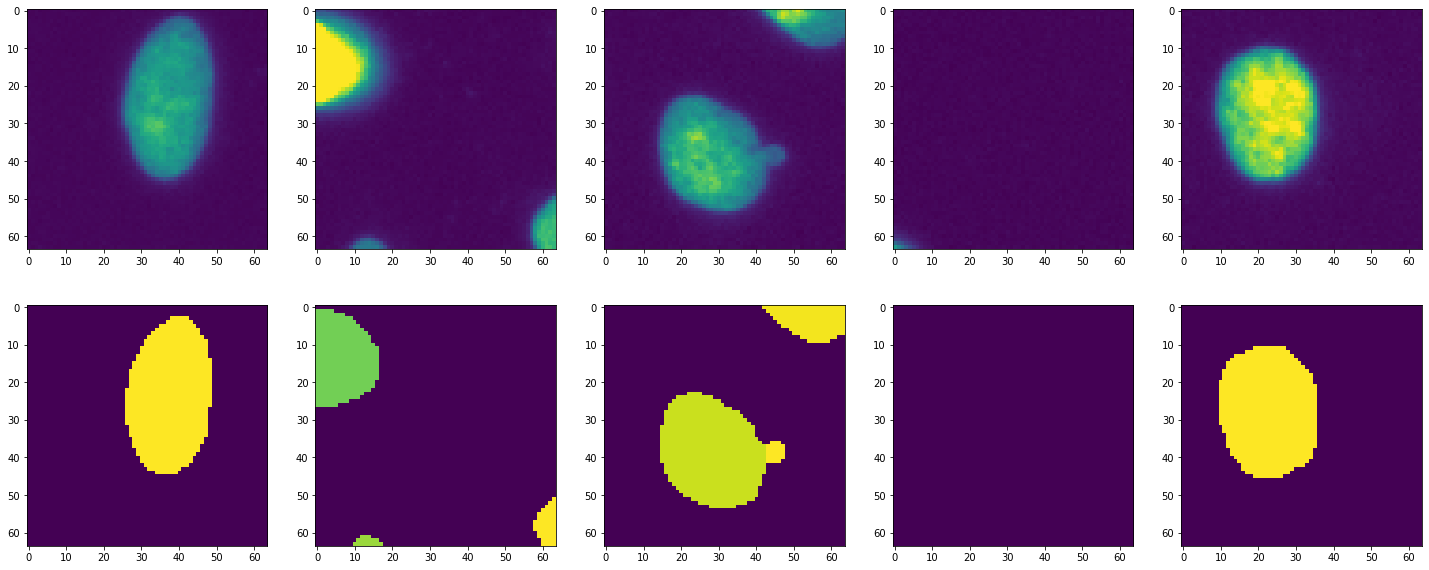

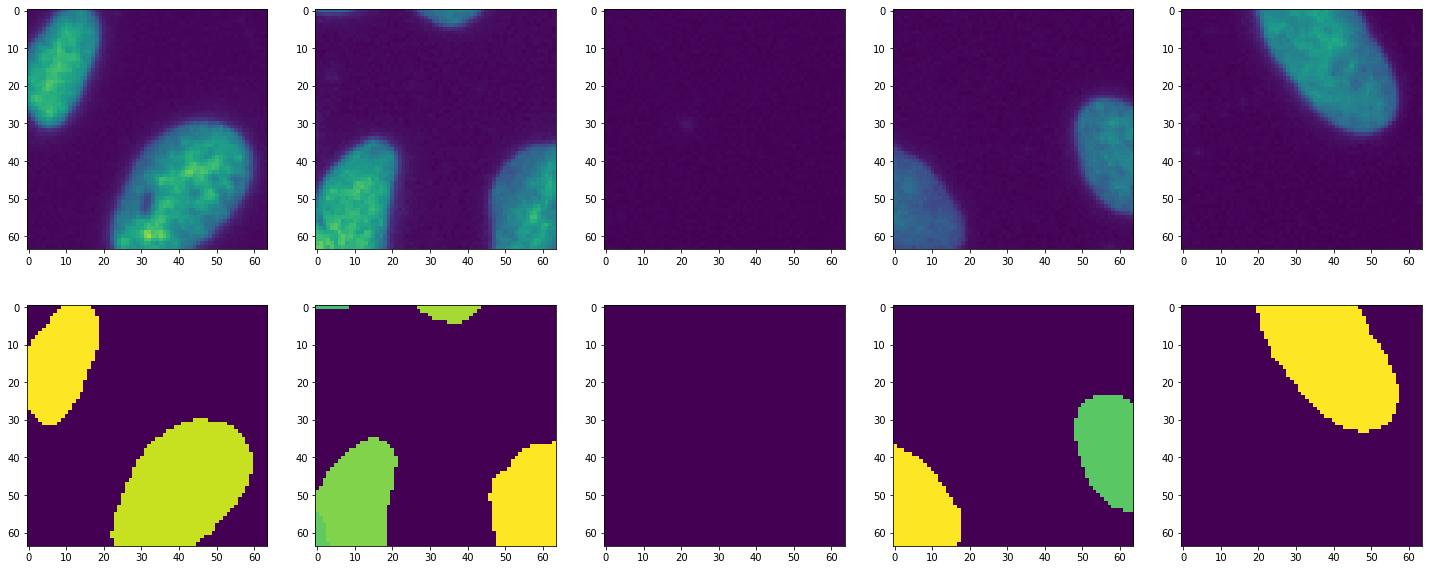

In [72]:
for batch in dl:
    plt.figure(figsize=(25,10))
    plt.subplot(2,5,1)
    plt.imshow(batch[0][0,...,0], vmin=0, vmax=1)
    plt.subplot(2,5,2)
    plt.imshow(batch[0][1,...,0], vmin=0, vmax=1)
    plt.subplot(2,5,3)
    plt.imshow(batch[0][2,...,0], vmin=0, vmax=1)
    plt.subplot(2,5,4)
    plt.imshow(batch[0][3,...,0], vmin=0, vmax=1)
    plt.subplot(2,5,5)
    plt.imshow(batch[0][4,...,0], vmin=0, vmax=1)
    plt.subplot(2,5,6)
    plt.imshow(batch[1][0,...,0])
    plt.subplot(2,5,7)
    plt.imshow(batch[1][1,...,0])
    plt.subplot(2,5,8)
    plt.imshow(batch[1][2,...,0])
    plt.subplot(2,5,9)
    plt.imshow(batch[1][3,...,0])
    plt.subplot(2,5,10)
    plt.imshow(batch[1][4,...,0])
    plt.show()

In [55]:
batch[0].shape

torch.Size([5, 64, 64, 1])